In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score, accuracy_score
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

import warnings
warnings.filterwarnings('ignore')

# Exploring the Dataset

In [2]:
data = pd.read_csv("data/starcraft_player_data.csv")
data.shape

(3395, 20)

In [3]:
# checking how much data is given
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [4]:
data.tail()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
3394,10095,8,?,?,?,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


### Missing Values in Age, HoursPerWeek, TotalHours
I noticed while printing the tail of the dataframe (and while getting the correlation matrix) that Age, HoursPerWeek, TotalHours do not have nan values, but have '?' for missing values.

In [5]:
# checking for nan values in the data
# no nan values present
data.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [6]:
data = data.replace('?', np.nan)

In [7]:
data.isna().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [8]:
data[data.isna().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17,20,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000


##### Note - The columns Age, HoursPerWeek, TotalHours have around similar missing values. Now, we can either drop it or try to impute them using the mean of nearest neighbors (KNNImputer). 
I do not want to drop it since the dataset only has 3395 rows and for the missing rows of Age, HoursPerWeek and Total hours, we have all the other data. I chose KNN imputation, where I will use selected variables to create a K Nearest Neighbor cluster and then use the cluster to impute the missing values

In [20]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data), columns = data.columns)
data_imputed['Age'] = pd.to_numeric(data_imputed['Age'].round())
data_imputed['HoursPerWeek'] = pd.to_numeric(data_imputed['HoursPerWeek'].round())

In [10]:
data_imputed.Age.value_counts()

21.0    394
20.0    362
18.0    325
22.0    314
19.0    313
23.0    259
16.0    256
17.0    248
24.0    225
25.0    168
26.0    136
27.0    111
28.0     73
29.0     52
30.0     32
31.0     29
32.0     21
35.0     17
33.0     15
34.0     15
36.0      8
38.0      5
37.0      5
40.0      4
41.0      3
39.0      3
43.0      1
44.0      1
Name: Age, dtype: int64

In [11]:
data_imputed.HoursPerWeek.value_counts()

10.0     411
8.0      390
20.0     348
12.0     331
6.0      323
28.0     280
24.0     233
16.0     223
4.0      219
14.0     182
2.0      108
42.0      92
30.0      54
36.0      50
19.0      37
56.0      33
18.0      26
40.0      12
70.0       9
48.0       7
32.0       5
50.0       5
21.0       3
96.0       2
84.0       2
60.0       2
0.0        1
72.0       1
90.0       1
98.0       1
140.0      1
80.0       1
168.0      1
112.0      1
Name: HoursPerWeek, dtype: int64

Rank Player_Count
1    167
2    347
3    553
4    811
5    806
6    621
7     35
8     55
Name: LeagueIndex, dtype: int64


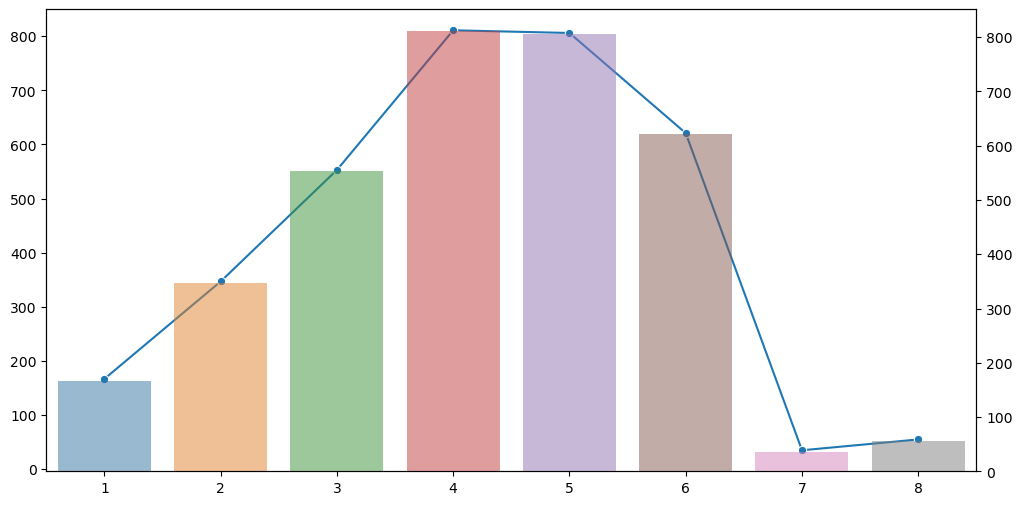

In [12]:
# Rank Distribution
rank_counts = data.LeagueIndex.value_counts().sort_index()
print("Rank Player_Count")
print(rank_counts)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data= rank_counts.values, marker='o', ax=ax1)
ax2 = ax1.twinx()
sns.barplot(x=rank_counts.index, y=rank_counts.values, alpha=0.5, ax=ax2)
plt.show()

In [13]:
data_imputed.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.635935,15.965243,957.998468,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.173323,11.871884,17172.106437,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


[]

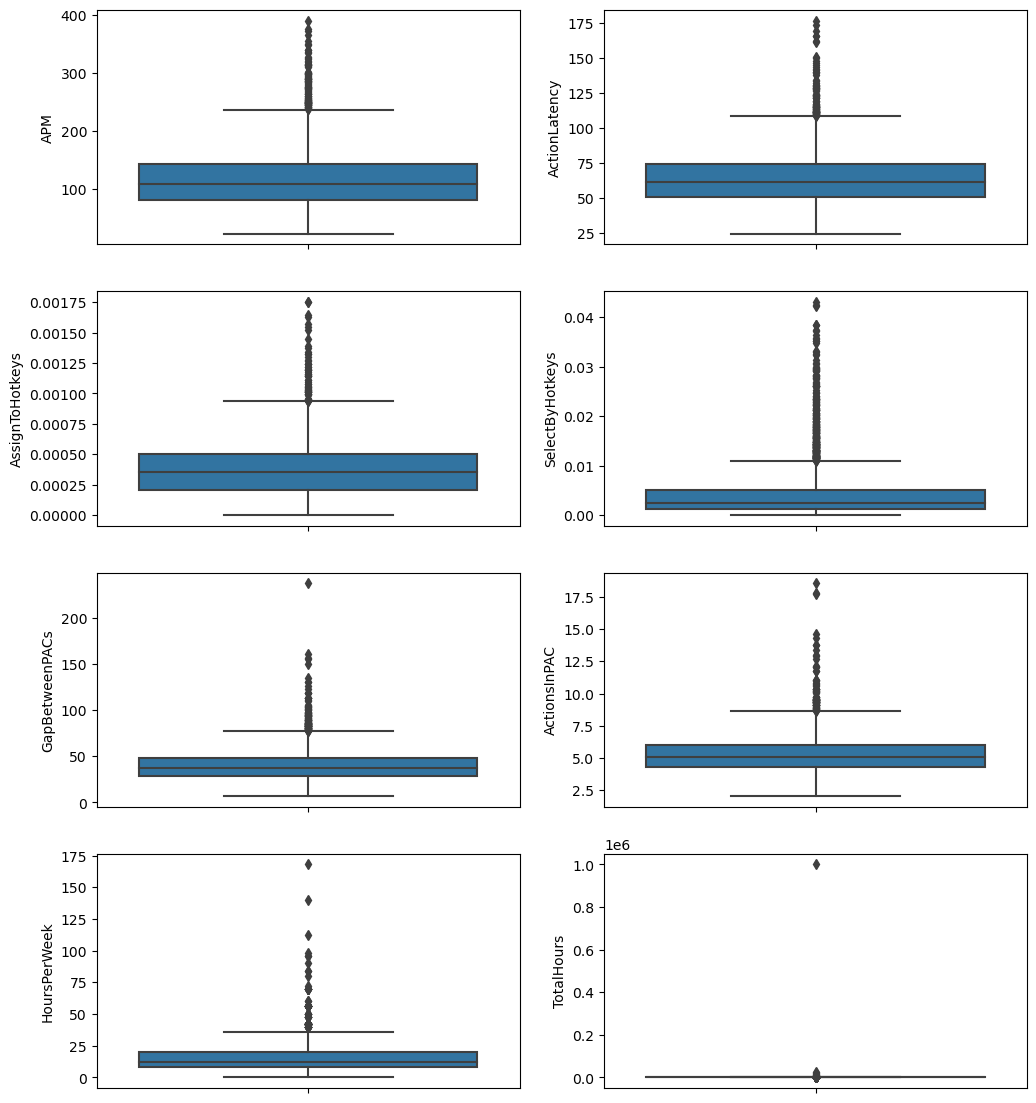

In [14]:
fig2, ax2_1 = plt.subplots(4, 2, figsize=(12,14))
sns.boxplot(y=data_imputed.APM, ax=ax2_1[0][0])
sns.boxplot(y=data_imputed.ActionLatency, ax=ax2_1[0][1])
sns.boxplot(y=data_imputed.AssignToHotkeys, ax=ax2_1[1][0])
sns.boxplot(y=data_imputed.SelectByHotkeys, ax=ax2_1[1][1])
sns.boxplot(y=data_imputed.GapBetweenPACs, ax=ax2_1[2][0])
sns.boxplot(y=data_imputed.ActionsInPAC, ax=ax2_1[2][1])
sns.boxplot(y=data_imputed.HoursPerWeek, ax=ax2_1[3][0])
sns.boxplot(y=data_imputed.TotalHours, ax=ax2_1[3][1])
plt.show()

We clearly see that there is an outlier in TotalHours which we have to remove as it is not possible for an 18 year old to have 1000000 hours of gameplay. I also saw the difference it made in the correlation between TotalHours and the target variable as it went from around 0.02 to 0.26 (I just thought this was interesting given just one row was affecting the whole column)

In [15]:
data_imputed[data_imputed.TotalHours == data_imputed.TotalHours.max()]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
1793,5140.0,5.0,18.0,24.0,1000000.0,281.4246,0.023428,0.000799,5.0,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29.0,0.001328,6.0,0.0,0.0


In [16]:
data_imputed = data_imputed.drop(1793).reset_index(drop=True)

In [17]:
data_imputed[data_imputed.GapBetweenPACs == data_imputed.GapBetweenPACs.max()]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
1358,3899.0,1.0,16.0,16.0,80.0,37.31454,0.000192,0.000038,0.0,0.0,0.000346,0.000847,237.1429,161.6364,8.0909,18.0,0.000077,2.0,0.0,0.0


In [18]:
data_imputed.corr()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,1.000000,0.102586,0.080579,-0.015732,0.034291,0.159812,0.160982,0.136187,0.117358,0.074059,0.046578,0.089612,-0.102554,-0.087197,0.047242,0.032284,-0.011657,0.021214,-0.027080,0.003267
LeagueIndex,0.102586,1.000000,-0.128045,0.217715,0.263904,0.662814,0.490995,0.531128,0.351190,0.312618,0.233217,0.612208,-0.553198,-0.673945,0.143069,0.220567,0.295579,0.133560,0.148932,0.145830
Age,0.080579,-0.128045,1.000000,-0.184955,-0.033285,-0.201266,-0.124789,-0.104306,0.011697,0.036290,-0.022011,-0.195038,0.113943,0.239745,-0.046036,-0.024271,-0.091522,0.023266,-0.079150,-0.065581
HoursPerWeek,-0.015732,0.217715,-0.184955,1.000000,0.255747,0.240321,0.197472,0.158079,0.074512,0.087644,0.052008,0.176916,-0.137511,-0.191790,0.095903,0.064626,0.050641,0.037280,0.057907,0.074218
TotalHours,0.034291,0.263904,-0.033285,0.255747,1.000000,0.249000,0.205055,0.130998,0.088151,0.132819,0.088370,0.183148,-0.160895,-0.206847,0.080640,0.090374,0.100132,0.052434,0.042355,0.058752
APM,0.159812,0.662814,-0.201266,0.240321,0.249000,1.000000,0.840179,0.577809,0.361992,0.271752,0.322509,0.650898,-0.575502,-0.722349,0.384200,0.220240,0.349693,0.101263,0.136850,0.132287
SelectByHotkeys,0.160982,0.490995,-0.124789,0.197472,0.205055,0.840179,1.000000,0.503746,0.302396,0.197915,0.143477,0.397642,-0.304139,-0.414784,0.163187,0.082665,0.141394,0.006440,0.044661,0.061730
AssignToHotkeys,0.136187,0.531128,-0.104306,0.158079,0.130998,0.577809,0.503746,1.000000,0.420318,0.242523,0.193057,0.486249,-0.396733,-0.481791,0.093503,0.192538,0.182852,0.133061,0.144984,0.154796
UniqueHotkeys,0.117358,0.351190,0.011697,0.074512,0.088151,0.361992,0.302396,0.420318,1.000000,0.180625,0.141566,0.372105,-0.242779,-0.323091,-0.016431,0.264613,0.108102,0.225058,0.110411,0.102501
MinimapAttacks,0.074059,0.312618,0.036290,0.087644,0.132819,0.271752,0.197915,0.242523,0.180625,1.000000,0.242290,0.177593,-0.237728,-0.200115,0.134849,0.166510,0.077687,0.120798,0.040186,0.044476


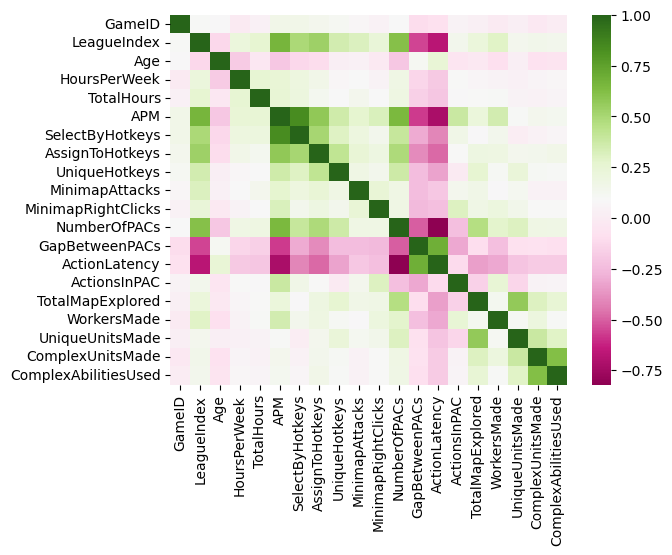

In [19]:
sns.heatmap(data_imputed.corr(), cmap="PiYG")
plt.show()

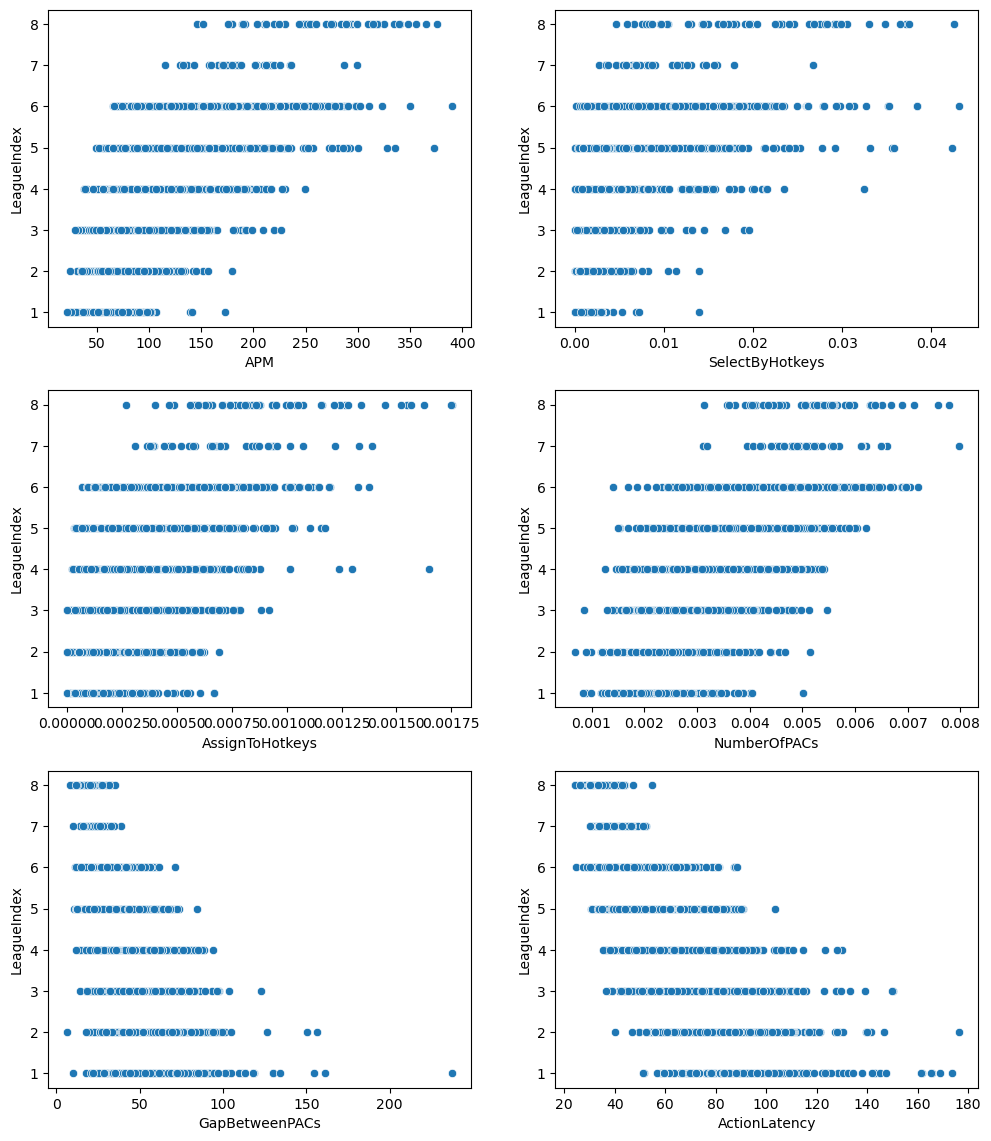

In [41]:
fig3, ax3_1 = plt.subplots(3, 2, figsize=(12,14))
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.APM, ax=ax3_1[0][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.SelectByHotkeys, ax=ax3_1[0][1])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.AssignToHotkeys, ax=ax3_1[1][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.NumberOfPACs, ax=ax3_1[1][1])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.GapBetweenPACs, ax=ax3_1[2][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.ActionLatency, ax=ax3_1[2][1])
plt.show()

#### Moderately to Highly Correlated Variables with Rank/LeagueIndex (considering values above 0.4 or below -0.6)
- APM - 0.66
- SelectByHotkeys - 0.49
- AssignToHotkeys - 0.53
- NumberOfPACs - 0.61
- GapBetweenPACs - -0.55
- ActionLatency - -0.67

#### Low Correlation with Rank/LeagueIndex
- UniqueHotkeys - 0.35
- MinimapAttacks - 0.31
- WorkersMade - 0.29
- TotalHours - 0.26

Plotting the variables with the ranks shows us that these independent variables do form a pattern that can help predict the ranks.

##### Note - We could use Pearson Correlation measure to select variables that best predict the target variable, however, the variables to be selected are also highly correlated with other selected variables which leads to multicollinearity. Therefore, I will not use Pearson Correlation for feature selection.  

# Selecting Variables

In [74]:
col_drop = ['GameID']
data_imputed = data_imputed.drop(columns=col_drop)

# Modeling

In [96]:
#Creating model class so that testing and tuning is easy to run all the different models.
class Model_Data:
    def __init__(self, model_ud, datafile, scoring='roc_auc_ovr', col="LeagueIndex"):
        self.df = datafile
        self.user_defined_model=model_ud
        self.col=col
        self.X= self.df.loc[:, ~self.df.columns.isin([self.col])]
        self.y = self.df[self.col]
        self.scoring = scoring
        
    def split(self, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, 
                                                                               stratify=self.y, random_state = 42)
    
    @staticmethod
    def scaledata(X_train, X_test):
        scaler = StandardScaler()
        idx=X_train.columns.get_loc("is_lhb")
        colnames = X_train.columns[0:idx]
        features_train= X_train[colnames]
        features_test= X_test[colnames]
        scaler.fit(features_train)
        features_train = scaler.transform(features_train)
        X_train[colnames] = features_train
        features_test = scaler.transform(features_test)
        X_test[colnames] = features_test
        return X_train, X_test
            
    def tune(self, params):

        cv = StratifiedKFold(n_splits=3)
        self.rand_search = GridSearchCV(estimator=self.user_defined_model, param_grid=params, n_jobs=8, 
                                         cv=cv, scoring=self.scoring, verbose=2)

            
        self.rand_search = self.rand_search.fit(self.X_train, self.y_train)
        # summarize results
        print("Best: %f using %s" % (self.rand_search.best_score_, self.rand_search.best_params_))

        means = self.rand_search.cv_results_['mean_test_score']
        stds = self.rand_search.cv_results_['std_test_score']
        parameters = self.rand_search.cv_results_['params']
        for mean, stdev, parameters in zip(means, stds, parameters):
            print("%f (%f) with: %r" % (mean, stdev, parameters))
            
    def tune_comp(self, params):

        cv = StratifiedKFold(n_splits=2)
        self.rand_search = RandomizedSearchCV(estimator=self.user_defined_model, param_grid=params, n_jobs=8,
                                     cv=cv, scoring=self.scoring, verbose=2)
            
        self.rand_search = self.rand_search.fit(self.X, self.y)
        # summarize results
        print("Best: %f using %s" % (self.rand_search.best_score_, self.rand_search.best_params_))

        means = self.rand_search.cv_results_['mean_test_score']
        stds = self.rand_search.cv_results_['std_test_score']
        parameters = self.rand_search.cv_results_['params']
        for mean, stdev, parameters in zip(means, stds, parameters):
            print("%f (%f) with: %r" % (mean, stdev, parameters))
    
    def fit(self):
        self.user_defined_model.set_params(**self.rand_search.best_params_)
        self.user_defined_model = self.user_defined_model.fit(self.X_train, self.y_train)
        
    def fit_comp(self):
        self.user_defined_model.set_params(**self.rand_search.best_params_)
        self.user_defined_model = self.user_defined_model.fit(self.X, self.y)
    
    def predict(self, input_value=None):
        if input_value == None:
            result = self.user_defined_model.predict(self.X_test)
        else: 
            result = self.user_defined_model.predict(np.array([input_value]))
        return result

    def AccuracyReport(self, predictions, input_value=None):
        if input_value == None:
            print(confusion_matrix(self.y_test,predictions))
            print(classification_report(self.y_test,predictions))
            acc2 = balanced_accuracy_score(self.y_test,predictions)
            acc3 = accuracy_score(self.y_test,predictions)
            print("Balanced Accuracy Score --> ",acc2)
            print("Accuracy Score --> ", acc3)
        else:
            print(confusion_matrix(np.array([input_value]),predictions))
            print(classification_report(np.array([input_value]),predictions))
            acc2 = balanced_accuracy_score(np.array([input_value]),predictions)
            print("Balanced Accuracy Score --> ",acc2)

### Logistic Regression

In [102]:
log_model = Model_Data(LogisticRegression(multi_class='multinomial'), data_imputed)
log_model.split(test_size=0.3)
param_grid = {
    'penalty' : ['l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','sag','saga'],
    'max_iter' : [100, 500, 1000, 2000]
}

In [103]:
%%time
log_model.tune(param_grid)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits
Best: 0.837375 using {'C': 3792.690190732246, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.821775 (0.008379) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.827404 (0.004867) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.612983 (0.028875) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
0.589176 (0.011552) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.829530 (0.005613) with: {'C': 0.0001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0

In [104]:
log_model.fit()

In [105]:
coef_table = pd.DataFrame(log_model.user_defined_model.coef_, columns = [list(log_model.X.columns)])
coef_table

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,-0.045470,0.008175,-0.003001,-0.057759,-3.365128,-0.992837,-0.157403,-0.486275,-0.262618,0.160149,0.067124,0.059543,0.466731,-0.002021,-2.798074,0.142784,-0.175145,-0.321514
1,-0.050742,0.003369,-0.001614,-0.037220,6.998695,-1.220752,-0.145803,-0.315892,0.109438,-1.971108,0.060187,0.048985,0.485151,0.010073,-2.216610,0.053074,-0.561933,-0.583248
2,-0.046334,-0.006397,-0.000009,-0.004321,-16.092037,-1.483523,-0.098204,-2.462847,-0.867370,2.985804,0.046150,0.062576,0.165533,-0.009123,-1.633762,0.091916,-0.676049,-0.520791
3,-0.020371,-0.015406,0.000348,0.003951,-6.520308,-0.619749,-0.120093,-1.445046,0.643630,-2.169674,0.040488,0.038509,0.112187,-0.007793,-3.857612,0.114541,0.380106,-0.733689
4,-0.000810,-0.015497,0.001134,0.014685,-7.464234,0.037752,-0.028689,1.704298,0.107402,2.733144,0.028175,0.006891,0.040048,-0.020967,8.259043,0.087248,0.356336,0.869643
5,-0.038287,0.007351,0.001161,0.017456,19.185736,2.026415,0.059938,1.240968,-0.769900,-0.996021,0.002704,-0.026663,-0.134074,-0.015680,2.559805,0.071677,0.634419,1.465237
6,0.050512,0.031048,0.001440,0.018209,-0.131064,0.642291,0.215692,0.666158,0.020472,0.498524,-0.145978,-0.070720,-0.578086,0.050495,0.394325,-0.279189,0.144085,0.141784
7,0.151503,-0.012642,0.000540,0.045000,7.388342,1.610402,0.274563,1.098635,1.018946,-1.240820,-0.098849,-0.119120,-0.557489,-0.004984,-0.707115,-0.282051,-0.101819,-0.317422


In [106]:
predictions = log_model.predict()
log_model.AccuracyReport(predictions)

[[ 18  18   6   7   1   0   0   0]
 [ 16  32  23  31   2   0   0   0]
 [  3  26  42  81  12   2   0   0]
 [  2  15  21 134  57  14   0   0]
 [  0   4   9  80  97  51   1   0]
 [  0   0   0  15  67 101   1   2]
 [  0   0   0   0   1   8   0   2]
 [  0   0   0   0   0   7   0  10]]
              precision    recall  f1-score   support

         1.0       0.46      0.36      0.40        50
         2.0       0.34      0.31      0.32       104
         3.0       0.42      0.25      0.31       166
         4.0       0.39      0.55      0.45       243
         5.0       0.41      0.40      0.41       242
         6.0       0.55      0.54      0.55       186
         7.0       0.00      0.00      0.00        11
         8.0       0.71      0.59      0.65        17

    accuracy                           0.43      1019
   macro avg       0.41      0.38      0.39      1019
weighted avg       0.43      0.43      0.42      1019

Balanced Accuracy Score -->  0.3755271472737496
Accuracy Score -->  